In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [2]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        # comp. domain
        self.h = 0.01
        self.k = 0.01
        x = torch.arange(0,1+self.h, self.h)
        t = torch.arange(0,6+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic  = torch.sin(math.pi*ic[:,0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_bic = self.criterion(y_pred,self.y_train)
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        du_x_dX = torch.autograd.grad(
        du_dx, self.X,
        grad_outputs=torch.ones_like(du_dx),
        create_graph=True,
        retain_graph=True
        )[0]   # -> columns [u_xx, u_xt]

        du_t_dX = torch.autograd.grad(
        du_dt, self.X,
        grad_outputs=torch.ones_like(du_dt),
        create_graph=True,
        retain_graph=True
        )[0]   # -> columns [u_tx, u_tt]

        # Now extract individual components
        du_dxx = du_x_dX[:, 0]
        du_dtt = du_t_dX[:, 1]
        du_dxt = du_x_dX[:, 1]
        du_dtx = du_t_dX[:, 0]
        # c^2 = 1
        loss_pde = self.criterion(du_dtt, du_dxx)

        loss = loss_pde + loss_bic
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(10000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [5]:
# training
net = Net()
net.train()

c:\Users\jy23choi\AppData\Local\anaconda3\envs\pinn\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\jy23choi\AppData\Local\anaconda3\envs\pinn\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100 0.022012706845998764
200 0.020393546670675278
300 0.016204919666051865
400 0.013257027603685856
500 0.012458289042115211
600 0.011196030303835869
700 0.009868960827589035
800 0.008642956614494324
900 0.008146973326802254
1000 0.007723791990429163
1100 0.007573792245239019
1200 0.009448660537600517
1300 0.007302079349756241
1400 0.011951389722526073
1500 0.007126227952539921
1600 0.007569469511508942
1700 0.007018275558948517
1800 0.006955623161047697
1900 0.007166997995227575
2000 0.0068888901732862
2100 0.00684309471398592
2200 0.00687049375846982
2300 0.006779985036700964
2400 0.007012214045971632
2500 0.006731336936354637
2600 0.006698256358504295
2700 0.0066902064718306065
2800 0.0066543868742883205
2900 0.006764065939933062
3000 0.00661871861666441
3100 0.0065871793776750565
3200 0.006556818261742592
3300 0.006551792845129967
3400 0.006517282221466303
3500 0.0064864750020205975
3600 0.00658463267609477
3700 0.006450389977544546
3800 0.006417975760996342
3900 0.0063863755203783

In [6]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [7]:
h = 0.01
k = 0.01

x = torch.arange(0,1+h, h)
t = torch.arange(0,6+k, k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [8]:
X

tensor([[0.0000, 0.0000],
        [0.0000, 0.0100],
        [0.0000, 0.0200],
        ...,
        [1.0000, 5.9800],
        [1.0000, 5.9900],
        [1.0000, 6.0000]], device='cuda:0')

In [9]:
X.shape

torch.Size([60701, 2])

In [10]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred1 = model(X)
    y_pred1 = y_pred1.reshape(len(x),len(t)).cpu().numpy()

In [11]:
y_pred1.shape

(101, 601)

In [12]:
y_pred1

array([[-0.01858927, -0.0125756 , -0.00679068, ...,  0.09176391,
         0.09634187,  0.10097649],
       [ 0.0123147 ,  0.01807245,  0.02359175, ...,  0.08906164,
         0.09365463,  0.09829613],
       [ 0.04297265,  0.04848393,  0.05373558, ...,  0.08642199,
         0.09100882,  0.09566583],
       ...,
       [ 0.03051785,  0.03813549,  0.04531955, ...,  0.04063493,
         0.04310229,  0.04561042],
       [-0.00367089,  0.00437561,  0.01200148, ...,  0.04211304,
         0.04453826,  0.04699797],
       [-0.03828707, -0.02980097, -0.02171869, ...,  0.04363149,
         0.04600396,  0.04843041]], dtype=float32)

In [13]:
sns.set_style("white")
plt.figure(figsize=(5,5), dpi=3000)
sns.heatmap(y_pred1*10, cmap='jet')

<Axes: >

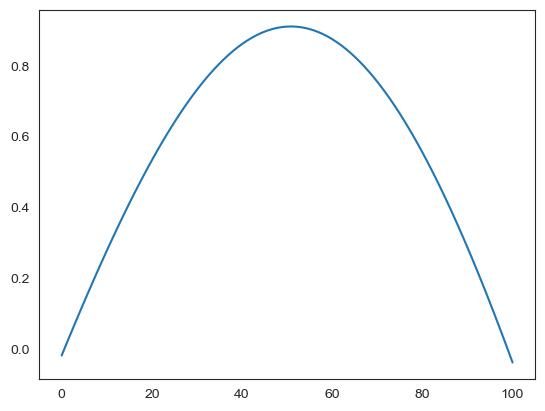

In [14]:
plt.plot(y_pred1[:,0])

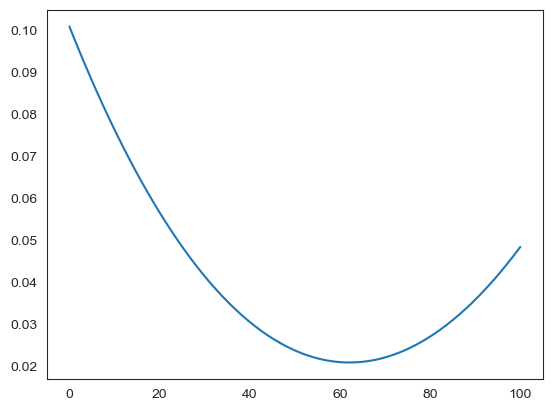

In [15]:
plt.plot(y_pred1[:,-1])

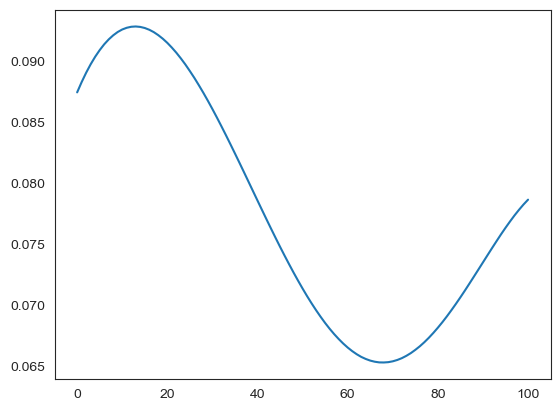

In [16]:
plt.plot(y_pred1[:,50])

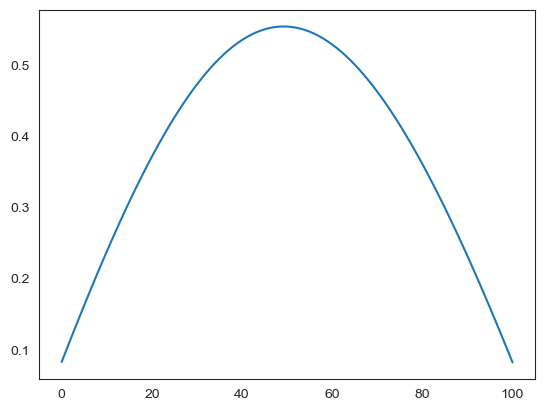

In [17]:
plt.plot(y_pred1[:,30])

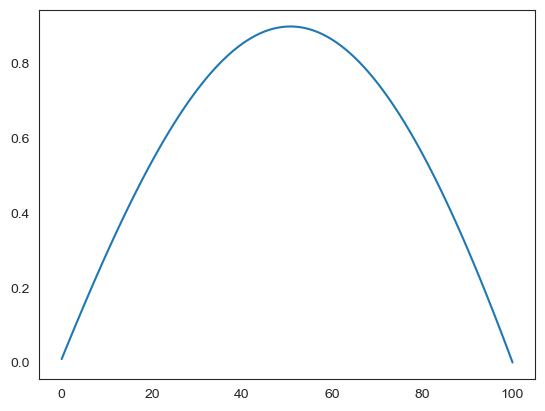

In [18]:
plt.plot(y_pred1[:,5])

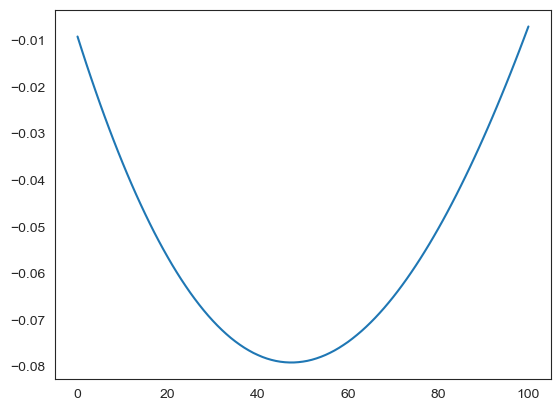

In [19]:
plt.plot(y_pred1[:,-30])

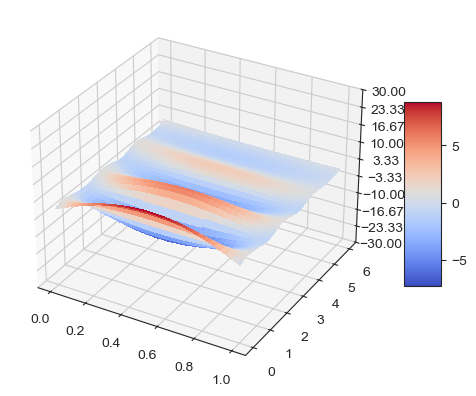

In [20]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

nx, nt = len(x), len(t)          # 101, 601
# Make 2D grids. Use 'ij' so X is (nx,nt) and T is (nx,nt)
X, T = np.meshgrid(x, t, indexing='ij')   # both -> (nx, nt)
# Ensure Z matches (nx, nt)
Z = 10*y_pred1

# Plot the surface.
surf = ax.plot_surface(X,T,Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-30,30)
##ax.set_xlim(-5, 65)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()